In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, math
import numpy as np
import torch
from torch.autograd import Variable 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from utils import *

In [44]:
nb_name = 'nb1'
model_path = 'weights/' + nb_name + '.pyt'
sample_rate = 24000

In [45]:
def sine_wave(freq, length, sample_rate=sample_rate) : 
    return np.sin(np.arange(length) * 2 * math.pi * freq / sample_rate).astype(np.float32)

In [46]:
signal = sine_wave(1, sample_rate)

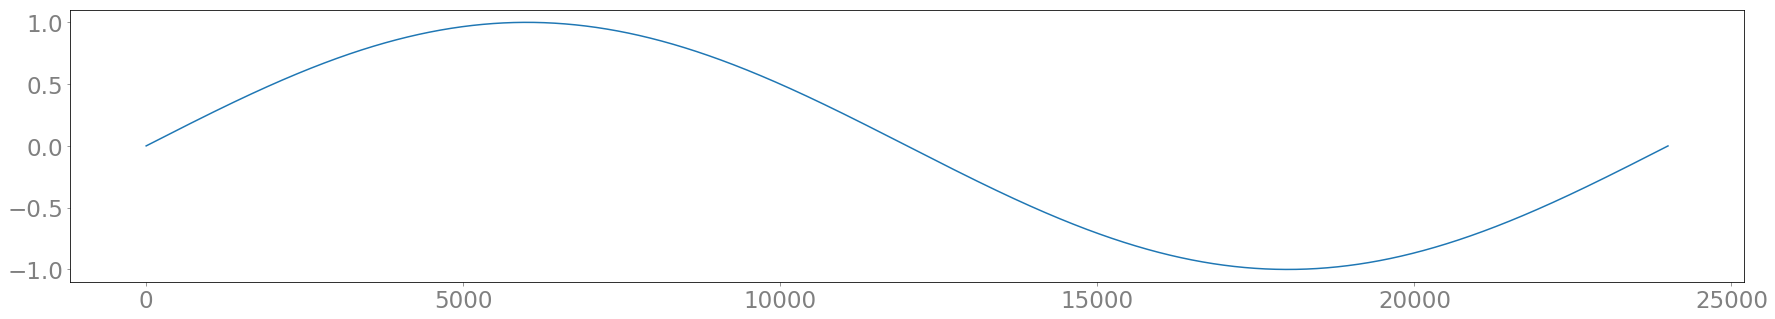

In [47]:
plot(signal)

## Define Model Classes

In [48]:
class FFTLayer(nn.Module) :
    def __init__(self, in_channels, out_channels, N) :
        super().__init__()
        self.N = N # Receptive Field for layer
        self.W_l = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.W_r = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.W_o = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x) :
        ''' Note: the paper states to pad by N (see 2.3.1)
            but I am padding by N/2 for now '''
        B, C, _ = x.size()
        padding = torch.zeros(B, C, self.N//2).cuda()
        x = torch.cat([padding, x], dim=-1)
        x_l = self.W_l(x[:, :, :-self.N//2])
        x_r = self.W_r(x[:, :, self.N//2:])
        x = F.relu(x_l + x_r)
        return F.relu(self.W_o(x))

In [49]:
class FFTNet(nn.Module) :
    def __init__(self, channels=256, depth=11, classes=256) :
        super().__init__()
        self.buffer = None
        self.classes = classes
        N_seq = [2**i for i in range(depth, 0, -1)]
        fft_layers = []
        for N in N_seq :
            in_channels = 1 if N == 2**depth else channels
            fft_layers += [FFTLayer(in_channels, channels, N)]
        self.fft_layers = nn.Sequential(*fft_layers)
        self.fc_out = nn.Linear(channels, classes)
        print('Receptive Field: %i samples' % 2**depth)
        num_params(self)    
            
    def forward(self, x) :
        x = self.fft_layers(x)
        x = self.fc_out(x.transpose(1, 2))
        return F.log_softmax(x, dim=-1)
                            
    def init_buffer(self) :
        x = torch.rand(1, 1, self.fft_layers[0].N).cuda()
        self.buffer = [x[:, :, self.fft_layers[0].N//2-1:]]
        for f in self.fft_layers :
            x_l = f.W_l(x[:, :, :-f.N//2])
            x_r = f.W_r(x[:, :, f.N//2:])
            x = F.relu(x_l + x_r)
            x = F.relu(f.W_o(x))
            self.buffer += [x[: ,:, f.N//4-1:]]
        
    def push(self, i, y) :
        self.buffer[i] = torch.cat([self.buffer[i], y], dim=-1)[:, :, 1:]
    
    def int2float(self, x) :
        return 2 * x.float() / (self.classes - 1) - 1
    
    def generate(self, seq_len) :
        with torch.no_grad() :
            c = 2 # Conditional Sampling (section 2.3.2)
            self.init_buffer()
            output = []
            start = time.time()
            for t in range(seq_len) :
                for i, f in enumerate(self.fft_layers) :
                    x_r = f.W_r(self.buffer[i][:, :, -1:])
                    x_l = f.W_l(self.buffer[i][:, :, :1])
                    x = F.relu(x_l + x_r)
                    x = F.relu(f.W_o(x))
                    self.push(i + 1, x)
                x = self.fc_out(x.squeeze(-1))
                posterior = F.softmax(c * x.view(-1), dim=0)
                dist = torch.distributions.Categorical(posterior)
                sample = self.int2float(dist.sample())
                output.append(sample)
                self.push(0, sample.view(1, 1, 1))
                speed = (t + 1) / (time.time() - start) 
                display('Generating: %i/%i, Speed: %.2f samples/sec', 
                        (t + 1, seq_len, speed))
        self.buffer = None
        return torch.stack(output).cpu().detach().numpy()

### Train

In [15]:
def train(model, optimizer, batch_size, seq_len, lr, steps) :

    data = sine_wave(freq=200, length=sample_rate * 300)
    data = torch.FloatTensor(data)
    data = data[:len(data)//batch_size*batch_size]
    data = data.view(batch_size, -1)
    y_data = ((data + 1) * 127.5).long()
    y_data = y_data[:, 1:]
    
    for p in optimizer.param_groups : p['lr'] = lr
    criterion = nn.NLLLoss().cuda()
    start = time.time()
    running_loss = 0
    
    for i in range(steps) :

        optimizer.zero_grad()

        rand_pos = np.random.randint(0, y_data.size(-1) - seq_len)

        x = data[:, rand_pos:rand_pos+seq_len]
        y = y_data[:, rand_pos:rand_pos+seq_len]

        x = x.cuda()
        y = y.cuda()

        y_hat = model(x.unsqueeze(1))
        y_hat = y_hat.transpose(1, 2).unsqueeze(-1)

        loss = criterion(y_hat, y.unsqueeze(-1))

        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        speed = (i + 1) / (time.time() - start)
        t = time_since(start)
        l = running_loss / (i + 1)

        display('Batches: %i/%i -- Loss: %.4f -- T: %s -- Speed: %.1f steps/sec ', 
                (i + 1, 10000, l, t, speed))

In [31]:
model = FFTNet().cuda()

Receptive Field: 2048 samples
Trainable Parameters: 2.106 million


In [10]:
optimizer = optim.Adam(model.parameters())

In [24]:
train(model, optimizer, batch_size=2, seq_len=5000, lr=1e-3, steps=10_000)

Batches: 10000/10000 -- Loss: 0.3687 -- T: 9m 23s -- Speed: 17.7 steps/sec

In [21]:
# torch.save(model.state_dict(), model_path)

In [32]:
# model.load_state_dict(torch.load(model_path)) 

In [41]:
out = model.generate(1000)

Generating: 1000/1000, Speed: 357.78 samples/sec

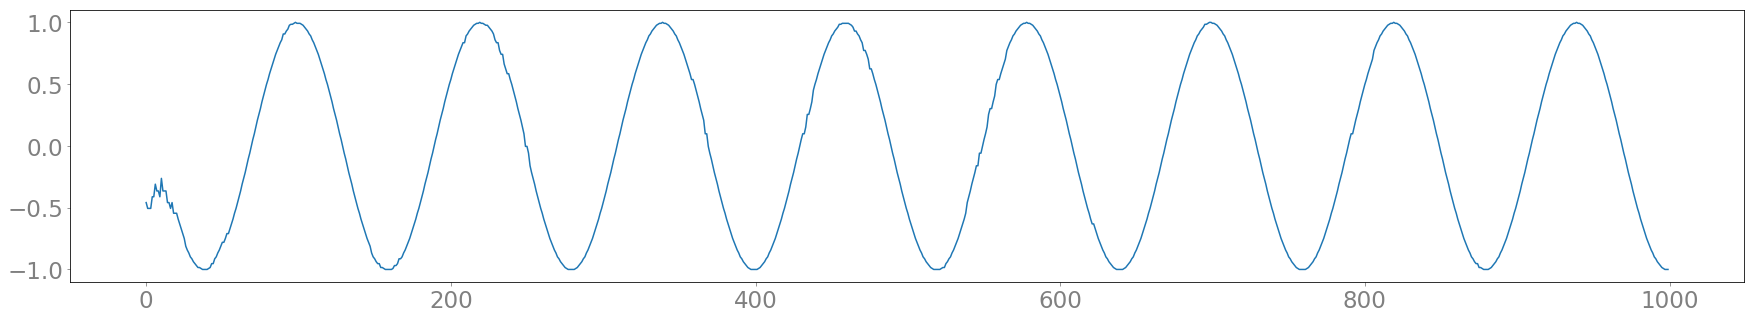

In [42]:
plot(out)